Version 1.0.0

# Ensembling

In this programming assignment you are asked to implement two ensembling schemes: simple linear mix and stacking.

We will spend several cells to load data and create feature matrix, you can scroll down this part or try to understand what's happening.

In [1]:
import pandas as pd
import numpy as np
import gc                           #garbage collection 模块 用于垃圾回收
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook      #进度条

from itertools import product   # 循环求对儿

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [2]:
import time
for i in tqdm_notebook(range(100)):  
     time.sleep(0.01)  

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


# Load data subset

Let's load the data from the hard drive first.

In [3]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')
shops = pd.read_csv('../readonly/final_project_data/shops.csv')
items = pd.read_csv('../readonly/final_project_data/items.csv')
item_cats = pd.read_csv('../readonly/final_project_data/item_categories.csv')

In [4]:
sales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
shops.head(1)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


In [6]:
items.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_cats.head(1)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0


And use only 3 shops for simplicity.

In [8]:
sales = sales[sales['shop_id'].isin([26, 27, 28])]

In [9]:
sales.shape

(301510, 6)

# Get a feature matrix

We now need to prepare the features. This part is all implemented for you.

In [10]:
grid = [] 

for i,block_num in enumerate(sales['date_block_num'].unique()):
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    print(cur_shops)
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    print(cur_items,len(cur_items))
    grid.append(np.array(list(product(*[cur_shops, cur_items[0:5], [block_num]])),dtype='int32'))
    b = list(product(cur_shops,cur_items,[block_num]))
    if i == 3: break
print(grid)
print(np.vstack(grid))

[28 27 26]
[7738 7737 7770 ..., 6397 6405 6510] 3860
[26 27 28]
[16409 16755 16450 ..., 13433 13435 13495] 3400
[28 27 26]
[4496 4446 4485 ...,   68   43   34] 3558
[28 27 26]
[3903 3738 3739 ..., 3624 3850 3718] 3245
[array([[  28, 7738,    0],
       [  28, 7737,    0],
       [  28, 7770,    0],
       [  28, 7664,    0],
       [  28, 7814,    0],
       [  27, 7738,    0],
       [  27, 7737,    0],
       [  27, 7770,    0],
       [  27, 7664,    0],
       [  27, 7814,    0],
       [  26, 7738,    0],
       [  26, 7737,    0],
       [  26, 7770,    0],
       [  26, 7664,    0],
       [  26, 7814,    0]], dtype=int32), array([[   26, 16409,     1],
       [   26, 16755,     1],
       [   26, 16450,     1],
       [   26, 16451,     1],
       [   26, 16471,     1],
       [   27, 16409,     1],
       [   27, 16755,     1],
       [   27, 16450,     1],
       [   27, 16451,     1],
       [   27, 16471,     1],
       [   28, 16409,     1],
       [   28, 16755,     1],
 

In [11]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
gb.head(50)

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,item_cnt_day
,,,,target
0,26,27,0,1.0
1,26,27,10,1.0
2,26,27,14,1.0
3,26,28,8,1.0
4,26,28,9,1.0
5,26,30,1,22.0
6,26,30,2,13.0
7,26,30,3,6.0
8,26,30,4,2.0


In [12]:
gb.columns.values

array([('shop_id', ''), ('item_id', ''), ('date_block_num', ''),
       ('item_cnt_day', 'target')], dtype=object)

In [13]:
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
gb.head()

,shop_id,item_id,date_block_num,target
0,26,27,0,1.0
1,26,27,10,1.0
2,26,27,14,1.0
3,26,28,8,1.0
4,26,28,9,1.0


In [14]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32')) # * 是解包功能

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)  #stack list vertically

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [15]:
all_data.loc[all_data.item_id==7738]

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,28,7738,0,4.0,7057.0,11.0
3860,27,7738,0,4.0,5548.0,11.0
7720,26,7738,0,3.0,2331.0,11.0
12965,26,7738,1,2.0,2597.0,5.0
16365,27,7738,1,0.0,4546.0,5.0
19765,28,7738,1,3.0,5438.0,5.0
34861,28,7738,3,0.0,4910.0,1.0
38106,27,7738,3,0.0,3946.0,1.0
41351,26,7738,3,1.0,2381.0,1.0
52029,28,7738,5,4.0,7056.0,8.0


After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [16]:
cols_to_rename = list(all_data.columns.difference(index_cols)) 
cols_to_rename

['target', 'target_item', 'target_shop']

In [17]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

To this end, we've created a feature matrix. It is stored in `all_data` variable. Take a look:

In [18]:
all_data.head(5)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0,37
2,28,10991,12,1.0,6949.0,5.0,1.0,3.0,8499.0,0.0,0.0,0.0,0.0,1.0,5609.0,0.0,2.0,6753.0,2.0,4.0,7521.0,0.0,0.0,0.0,40
3,28,10988,12,1.0,6949.0,2.0,2.0,5.0,8499.0,4.0,5.0,6454.0,5.0,6.0,5609.0,0.0,2.0,6753.0,0.0,0.0,0.0,0.0,0.0,0.0,40
4,28,11002,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [19]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [20]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

In [21]:
X_train.values

array([[  2.80000000e+01,   1.09940000e+04,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   3.70000000e+01],
       [  2.80000000e+01,   1.09920000e+04,   3.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   3.70000000e+01],
       [  2.80000000e+01,   1.09910000e+04,   1.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   4.00000000e+01],
       ..., 
       [  2.70000000e+01,   5.24000000e+03,   0.00000000e+00, ...,
          4.00000000e+00,   4.02600000e+03,   3.00000000e+01],
       [  2.70000000e+01,   5.24100000e+03,   0.00000000e+00, ...,
          1.20000000e+01,   4.02600000e+03,   1.90000000e+01],
       [  2.70000000e+01,   5.27200000e+03,   0.00000000e+00, ...,
          3.80000000e+01,   4.02600000e+03,   3.00000000e+01]])

# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [22]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.743180


And the we run *LightGBM*.

In [23]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.738391


Finally, concatenate test predictions to get test meta-features.

In [24]:
X_test_level2 = np.c_[pred_lr, pred_lgb] 
X_test_level2

array([[ 13.45896153,  13.37831474],
       [  3.18599444,   2.55590212],
       [  2.5028209 ,   1.52356814],
       ..., 
       [  0.69860529,   0.41663964],
       [  0.12072911,   0.34056468],
       [  0.1755516 ,   0.32987826]])

### Train meta-features

**Now it is your turn to write the code**. You need to implement ***scheme f)*** from the reading material. Here, we will use duration **T** equal to month and **M=15**.  

That is, you need to get predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32. Use the same parameters as in above models.

In [25]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [43]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

tmp_index = 0

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      

    X_train_t = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test_t =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    y_train_t = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test_t =  all_data.loc[dates == cur_block_num, 'target'].values
    
    lr.fit(X_train_t.values, y_train_t)
    pred_lr_t = lr.predict(X_test_t.values)
    print(r2_score(y_test_t,pred_lr_t))
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_t, label=y_train_t), 100)
    pred_lgb_t = model.predict(X_test_t)
    print(r2_score(y_test_t,pred_lgb_t))
    
    former_index = tmp_index
    
    tmp_index = tmp_index + len(X_test_t)
    
    X_train_level2[former_index:tmp_index,0] = pred_lr_t
    X_train_level2[former_index:tmp_index,1] = pred_lgb_t
    
    
# Sanity check
assert np.all(np.isclose(X_train_level2.mean(axis=0), [ 1.50148988,  1.38811989]))

27
0.485960757512
0.270838154217
28
0.549966452149
0.470989058959
29
0.796330156142
0.61147046481
30
0.799709715712
0.641631493285
31
0.843262613691
0.68990172727
32
0.398219385956
0.399625614572


In [28]:
X_train_level2.mean(axis=0)

array([ 1.50148988,  1.38811989])

Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig *scatter plot* between the two metafeatures. Plot the scatter plot below. 

In [ ]:
# YOUR CODE GOES HERE
plt.figure(figsize=(9,6))

#rand 均匀分布和 randn高斯分布
x=np.random.randn(1,n)
y=np.random.randn(1,n)
T=np.arctan2(x,y)
plt.scatter(x,y,c=T,s=25,alpha=0.4,marker='o')
#T:散点的颜色
#s：散点的大小
#alpha:是透明程度
plt.show()

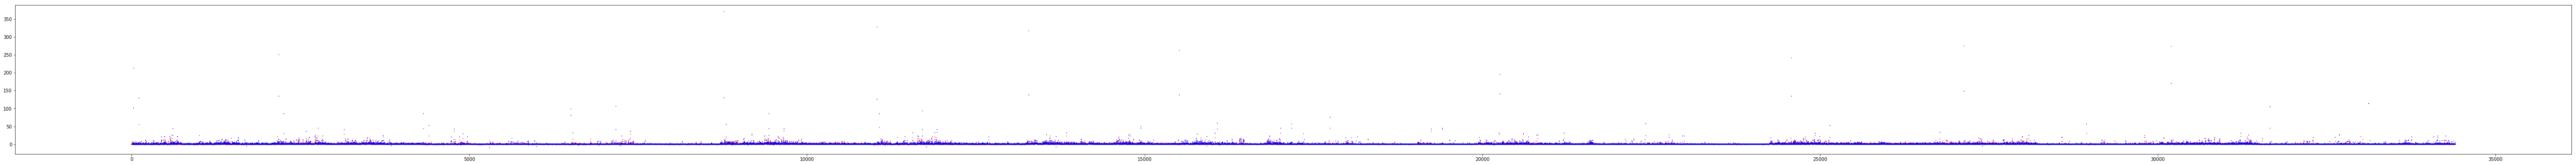

In [40]:
plt.figure(figsize=(100,6))
indexs = np.arange(0,X_train_level2.shape[0])
plt.scatter(indexs,X_train_level2[:,0],s=0.5,c='r')
plt.scatter(indexs,X_train_level2[:,1],s=0.5,c='b')
plt.show()

# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$. 

In [44]:
alphas_to_try = np.linspace(0, 1, 1001)

best_alpha = 0
r2_train_simple_mix = 0

for alpha in tqdm_notebook(alphas_to_try):
    mix = alpha*X_train_level2[:,0] + (1-alpha)*X_train_level2[:,1]
    tmp_score = r2_score(y_train_level2,mix)
    if tmp_score > r2_train_simple_mix: 
        r2_train_simple_mix=tmp_score
        best_alpha = alpha      

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))


Best alpha: 0.765000; Corresponding r2 score on train: 0.627255


Now use the $\alpha$ you've found to compute predictions for the test set 

In [45]:
test_preds = best_alpha*X_test_level2[:,0] + (1-best_alpha)*X_test_level2[:,1]
r2_test_simple_mix = r2_score(y_test, test_preds)

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)

Test R-squared for simple mix is 0.781144


### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [48]:
# YOUR CODE GOES HERE
lr.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Compute R-squared on the train and test sets.

In [51]:
train_preds = lr.predict(X_train_level2)
r2_train_stacking = r2_score(y_train_level2, train_preds)

test_preds = lr.predict(X_test_level2)
r2_test_stacking = r2_score(y_test, test_preds)

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Test  R-squared for stacking is %f' % r2_test_stacking)

Train R-squared for stacking is 0.632176
Test  R-squared for stacking is 0.771297


Interesting, that the score turned out to be lower than in previous method. Although the model is very simple (just 3 parameters) and, in fact, mixes predictions linearly, it looks like it managed to overfit. **Examine and compare** train and test scores for the two methods. 

And of course this particular case does not mean simple mix is always better than stacking.

We all done! Submit everything we need to the grader now.

In [52]:
from grader import Grader
grader = Grader()

grader.submit_tag('best_alpha', best_alpha)

grader.submit_tag('r2_train_simple_mix', r2_train_simple_mix)
grader.submit_tag('r2_test_simple_mix',  r2_test_simple_mix)

grader.submit_tag('r2_train_stacking', r2_train_stacking)
grader.submit_tag('r2_test_stacking',  r2_test_stacking)

Current answer for task best_alpha is: 0.765
Current answer for task r2_train_simple_mix is: 0.627255043446
Current answer for task r2_test_simple_mix is: 0.781144169579
Current answer for task r2_train_stacking is: 0.632175561459
Current answer for task r2_test_stacking is: 0.771297132342


In [56]:
STUDENT_EMAIL = 'mhyliyo@qq.com'
STUDENT_TOKEN = 'SfNB1aYkX3GQZJIt'
grader.status()

You want to submit these numbers:
Task best_alpha: 0.765
Task r2_train_simple_mix: 0.627255043446
Task r2_test_simple_mix: 0.781144169579
Task r2_train_stacking: 0.632175561459
Task r2_test_stacking: 0.771297132342


In [57]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
